# Data Processing of Accelerometer Data
This notebook arranged for extracting and processing accelerometer data, especially from Piezotronic (National Instruments) and Digiducer devices. This notebook is arranged as the following work order
1. Extract acceleration data from the obtained measurement file
2. Interpret acceleration data in both time and frequency domain 
3. Convert the acceleration data into velocity and diplacement units
4. Evalute all vibrations data based on defined standard 

### Pre processing step
All necessary library are imported 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tkinter import filedialog as fd
from additional_functions import *

### Working on Digiducer Data
This section focused on extracting and processing data form Digiducer sensor

#### 1. Extract and visualize data from digiducer data (full sequences)

Data extracted from selected file
The data was successfully loaded


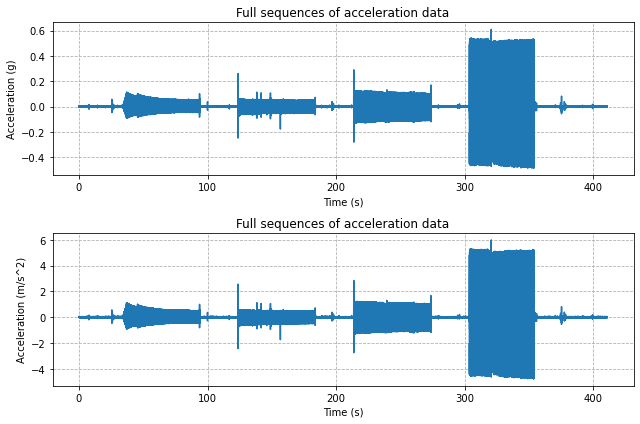

In [2]:
# extract digiducer data
time, accA, accB = extract_digiducer()
print("The data was successfully loaded")

# time based plot of full sequences of loaded data
fig1 = plt.figure(figsize=(9,6), tight_layout=True)
ax1 = fig1.add_subplot(211)
ax1.set_facecolor('white')
ax1.grid(True,which='both',ls='--')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (g)")
ax1.set_title("Full sequences of acceleration data")
line1, = ax1.plot(time, accB)

# Convert acceleration data units from g into m/s^2
g_converter = 9.80665   # a constant, 1 g ~ 9.80665 m/s^2 
accA = accA * g_converter
accB = accB * g_converter

# Plot the acceleration data (in m/s^2 unit)
ax2 = fig1.add_subplot(212)
ax2.set_facecolor('white')
ax2.grid(True,which='both',ls='--')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Acceleration (m/s^2)")
ax2.set_title("Full sequences of acceleration data")
line2, = ax2.plot(time, accB)



#### 2a. Segmenting the acceleration data on each frequencies stimulus (on time domain) and visualizing it

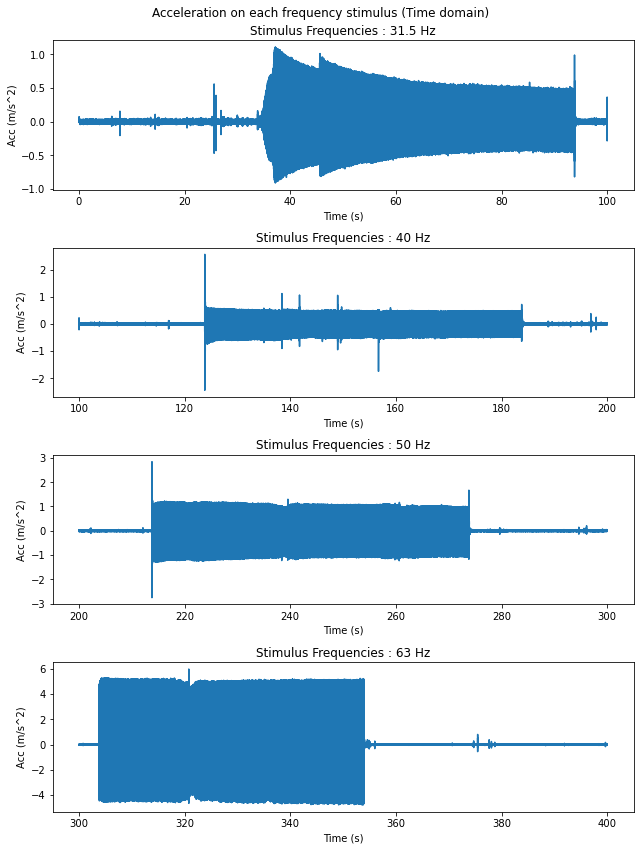

In [3]:
# Segmenting the data for each sequence of stimulus (pure tones having frequencies of 31.5; 40; 50; and 63 Hz)
digiducer_fs = 8000
freq_stimulus = ["31.5", "40", "50", "63"]
datapoints = [
    [0*digiducer_fs, 100*digiducer_fs],
    [100*digiducer_fs, 200*digiducer_fs],
    [200*digiducer_fs, 300*digiducer_fs],
    [300*digiducer_fs, 400*digiducer_fs],
    ]

segmented_data = segmenting_data(accB, datapoints)

# interpret acceleration in time domain data for each frequencies
fig2 = plt.figure(figsize=(9,12), tight_layout=True)
fig2.suptitle("Acceleration on each frequency stimulus (Time domain)")
for i in range(len(datapoints)):
    fig2.add_subplot(len(datapoints),1,i+1)
    plt.plot(time[datapoints[i][0]:datapoints[i][1]], segmented_data[i])
    plt.xlabel("Time (s)")
    plt.ylabel("Acc (m/s^2)")
    plt.title("Stimulus Frequencies : " + freq_stimulus[i] + " Hz")

plt.show()


#### 2b. Transofrming the obtained data to frequency domain using FFT

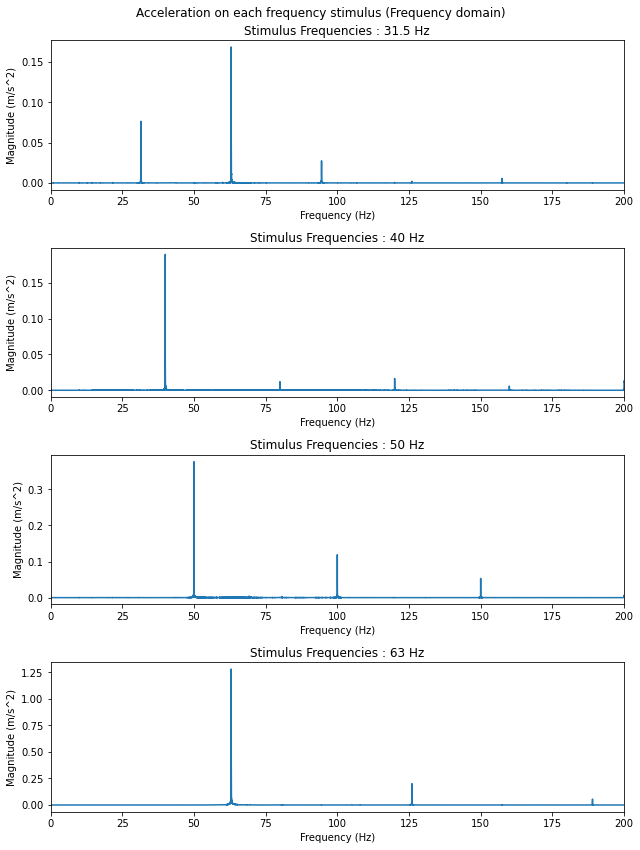

In [4]:
## Tranforming segmented data to frequency domain using Fast-Fourier Transform
fig3 = plt.figure(figsize=(9,12), tight_layout=True)
fig3.suptitle("Acceleration on each frequency stimulus (Frequency domain)")
for i in range(len(datapoints)):
    fig3.add_subplot(len(datapoints),1,i+1)
    
    # applying FFT
    acc = segmented_data[i]
    nfft = int(pow(2, np.ceil(np.log2(len(acc)))))
    win = np.hamming(len(acc))
    freq = (digiducer_fs/2) * np.arange(0,1,1/(nfft/2+1))

    ACC = 2/len(acc) * np.fft.fft(win*acc, nfft)

    plt.plot(freq, abs(ACC)[0:int(nfft/2+1)])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (m/s^2)")
    plt.xlim([0, 200])
    plt.title("Stimulus Frequencies : " + freq_stimulus[i] + " Hz")

plt.show()

#### 3a. Convert the acceleration data into velocity units
Converting data carried out by applying omega arithmatic algorithm, which integrating acceleration data to upper level on frequency domain. The detailed information about the algorithm and its application can be seen [here](http://prosig.com/wp-content/uploads/pdf/blogArticles/OmegaArithmetic.pdf).

/usr/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


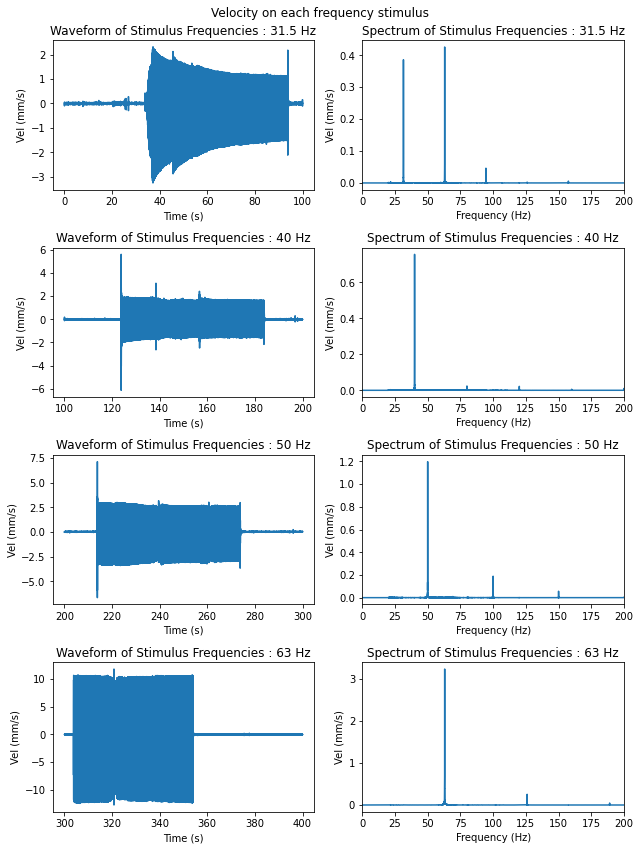

In [5]:
# Convert each acceleration (segmented) data into velocity units
vel = []
cf_frequency = 20

fig4 = plt.figure(figsize=(9,12), tight_layout=True)
fig4.suptitle("Velocity on each frequency stimulus")

for i in range(len(segmented_data)):
    vel_data, VEL_data, freq_data = omega_arithmatic(segmented_data[i], digiducer_fs, cf_frequency)
    vel.append(vel_data)

    fig4.add_subplot(len(segmented_data), 2, 2*i+1)
    plt.plot(time[datapoints[i][0]:datapoints[i][1]], vel_data*1e3)
    plt.xlabel("Time (s)")
    plt.ylabel("Vel (mm/s)")
    plt.title("Waveform of Stimulus Frequencies : " + freq_stimulus[i] + " Hz")

    fig4.add_subplot(len(segmented_data), 2, 2*(i+1))
    plt.plot(freq_data, abs(VEL_data)*1e3)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Vel (mm/s)")
    plt.xlim([0, 200])
    plt.title("Spectrum of Stimulus Frequencies : " + freq_stimulus[i] + " Hz")
    

#### 3b. Convert the acceleration data into displacement units

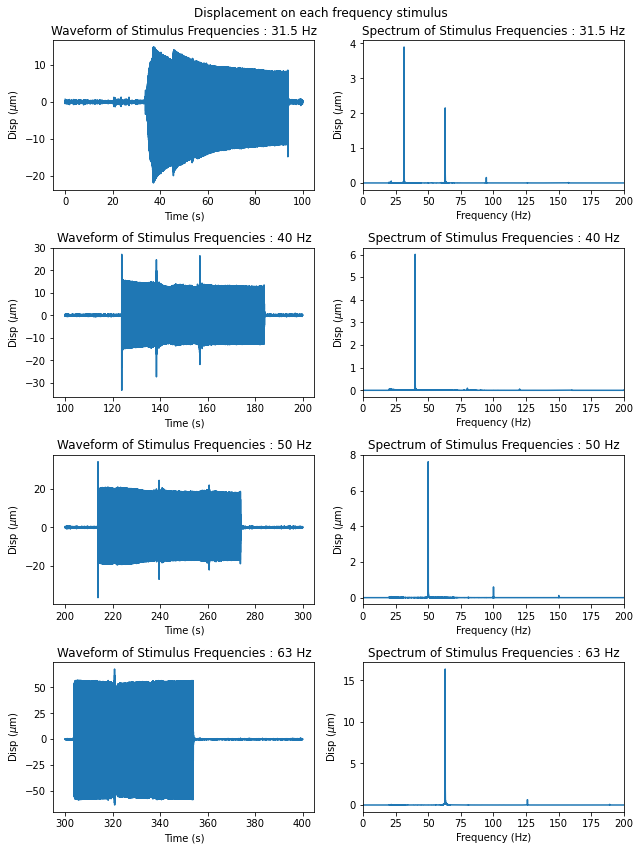

In [43]:
# Convert each acceleration (segmented) data into velocity units
disp = []
cf_frequency = 20

fig5 = plt.figure(figsize=(9,12), tight_layout=True)
fig5.suptitle("Displacement on each frequency stimulus")

for i in range(len(segmented_data)):
    disp_data, DISP_data, freq_data = omega_arithmatic(vel[i], digiducer_fs, cf_frequency)
    disp.append(disp_data)

    fig5.add_subplot(len(segmented_data), 2, 2*i+1)
    plt.plot(time[datapoints[i][0]:datapoints[i][1]], disp_data*1e6)
    plt.xlabel("Time (s)")
    plt.ylabel("Disp ($\mu$m)")
    plt.title("Waveform of Stimulus Frequencies : " + freq_stimulus[i] + " Hz")

    fig5.add_subplot(len(segmented_data), 2, 2*(i+1))
    plt.plot(freq_data, abs(DISP_data)*1e6)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Disp ($\mu$m)")
    plt.xlim([0, 200])
    plt.title("Spectrum of Stimulus Frequencies : " + freq_stimulus[i] + " Hz")

#### 4. Evaluate the obtained results based on vibration standard

In [32]:
# Obtain RMS of acceleration units
rms_acc = []
for i in range(len(segmented_data)):
    rms = np.sqrt(np.mean(segmented_data[i]**2))
    rms_acc.append(rms)
    print("RMS Value of Acceration at " + freq_stimulus[i] + " Hz is " + str(round(rms,2)) + " m/s^2")

RMS Value of Acceration at 31.5 is 0.25 m/s^2
RMS Value of Acceration at 40 is 0.23 m/s^2
RMS Value of Acceration at 50 is 0.51 m/s^2
RMS Value of Acceration at 63 is 2.22 m/s^2


In [35]:
# Obtain RMS Value of velocity units
rms_vel = []
for i in range(len(vel)):
    rms = np.sqrt(np.mean(np.real(vel[i]*1e3)**2))
    rms_vel.append(rms)
    print("RMS Value of Velocity at " + freq_stimulus[i] + " Hz is " + str(round(rms,2)) + " mm/s")

RMS Value of Velocity at 31.5 Hz is 0.77 mm/s
RMS Value of Velocity at 40 Hz is 0.91 mm/s
RMS Value of Velocity at 50 Hz is 1.55 mm/s
RMS Value of Velocity at 63 Hz is 5.52 mm/s


In [44]:
# Obtain RMS Value of displacement units
rms_disp = []
for i in range(len(disp)):
    rms = np.sqrt(np.mean(np.real(disp[i]*1e6)**2))
    rms_disp.append(rms)
    print("RMS Value of Displacement at " + freq_stimulus[i] + " Hz is " + str(round(rms,2)) + " μm")

RMS Value of Displacement at 31.5 Hz is 5.87 μm
RMS Value of Displacement at 40 Hz is 7.24 μm
RMS Value of Displacement at 50 Hz is 9.78 μm
RMS Value of Displacement at 63 Hz is 27.83 μm


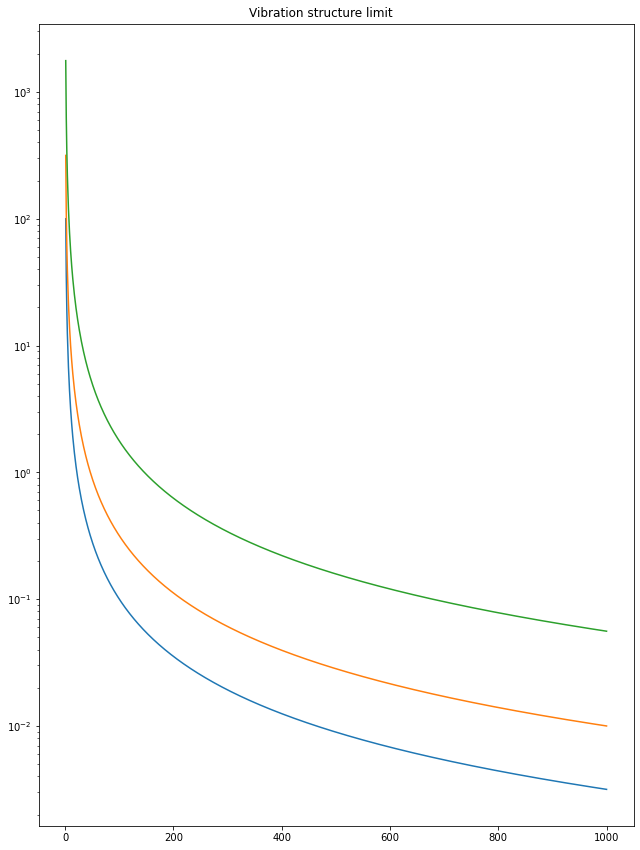

In [63]:
# Interpret the displacement result on graph (on progress)
vib_limit = [6.4, 64, 2000]    # limits on mm^2 / s^3
freq_limit = np.linspace(1, 1000, 1000)

fig5 = plt.figure(figsize=(9,12), tight_layout=True)
fig5.suptitle("Vibration structure limit")

line_lim = []
for i in range(len(vib_limit)):
    data = []
    for f in range(len(freq_limit)):
        x = (4 * pow(np.pi,2) / freq_limit[f]) * np.sqrt(vib_limit[i]/freq_limit[f])
        data.append(x)
    line_lim.append(data)
    plt.plot(freq_limit, data)
    plt.yscale('log')